# Week 4 - Alternate Attitude Control Formulations

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


## Functions from module 3

In [3]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next

In [4]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

In [5]:
def mrp_compose(s1, s2, mode="add"):
    """
    mrp_compose(s1, s2, mode)

    Q = mrp_compose(s1, s2, mode) provides the MRP vector corresponding to:

        mode = "add" :
            successive rotations s1 followed by s2

        mode = "sub" :
            relative rotation from s2 to s1

    This is a unified implementation of addMRP and subMRP.
    """

    # Ensure column-like vectors (but works with 1D arrays)
    s1 = np.asarray(s1, dtype=float).reshape(3,)
    s2 = np.asarray(s2, dtype=float).reshape(3,)

    s1_sq = np.dot(s1, s1)
    s2_sq = np.dot(s2, s2)
    s1_dot_s2 = np.dot(s1, s2)
    s1_cross_s2 = np.cross(s1, s2)

    if mode == "add":
        # --- MRP addition (successive rotations) ---
        q = ((1 - s1_sq) * s2 + (1 - s2_sq) * s1 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq - 2 * s1_dot_s2)

    elif mode == "sub":
        # --- MRP subtraction (relative attitude) ---
        q = ((1 - s2_sq) * s1 - (1 - s1_sq) * s2 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq + 2 * s1_dot_s2)

    else:
        raise ValueError("mode must be 'add' or 'sub'")

    return mrp_shadow(q)

## CC1, Q4

In [6]:
def cc1_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC1 tracking controller with torque saturation.

    Implements the Coursera tracking law (L assumed zero here):
        u = -K*sigma_BR - [P]*omega_BR
            + I*(omega_dot_RN_B - omega_BN_B x omega_RN_B)
            + omega_BN_B x (I*omega_BN_B)
            - modelL_B

    with a magnitude saturation:
        if ||u|| <= u_max: use u
        else:             use u_max * u / ||u||

    Inputs
    ------
    state:
        "sigma_BN"    : MRPs of B relative N
        "omega_BN_B"  : angular rate of B wrt N, expressed in B [rad/s]
    ref:
        "sigma_RN"        : MRPs of R relative N
        "omega_RN_R"      : angular rate of R wrt N, expressed in R [rad/s]
        "omega_dot_RN_R"  : angular accel of R wrt N, expressed in R [rad/s^2]
    ctx:
        "I"     : inertia matrix in B
        "K"     : attitude gain (scalar)
        "P"     : rate gain (scalar) or (3,) or (3,3 diag)
        "u_max" : saturation limit on ||u|| [N*m] (required for this CC)
        "modelL_B" : modeled disturbance torque in B (default zeros)

    Returns
    -------
    u_B : control torque in B [N*m]
    """
    # --- unpack state ---
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    # --- unpack reference ---
    sigma_RN = np.asarray(ref.get("sigma_RN", np.zeros(3)), dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref.get("omega_RN_R", np.zeros(3)), dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref.get("omega_dot_RN_R", np.zeros(3)), dtype=float).reshape(3,)

    # --- unpack context ---
    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = np.asarray(ctx["P"], dtype=float)
    u_max = float(ctx.get("u_max", np.inf))
    modelL_B = np.asarray(ctx.get("modelL_B", np.zeros(3)), dtype=float).reshape(3,)

    # Make P behave like a diagonal gain matrix
    if P.ndim == 0:
        P_mat = float(P) * np.eye(3)
    elif P.shape == (3,):
        P_mat = np.diag(P)
    elif P.shape == (3, 3):
        P_mat = P
    else:
        raise ValueError("ctx['P'] must be scalar, (3,), or (3,3)")

    # -------------------------
    # 1) Attitude error sigma_BR
    # -------------------------
    # sigma_BR = sigma_BN (-) sigma_RN
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # -------------------------
    # 2) Rate error omega_BR_B
    # -------------------------
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    # -------------------------
    # 3) Feedforward tracking term
    # -------------------------
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    transport = np.cross(omega_BN_B, omega_RN_B)
    ff = I @ (omega_dot_RN_B - transport)

    # -------------------------
    # 4) Unsaturated control
    # -------------------------
    u_unsat = (
        -K * sigma_BR
        -P_mat @ omega_BR_B
        + ff
        + np.cross(omega_BN_B, I @ omega_BN_B)  # gyro cancellation
        - modelL_B
    )

    # -------------------------
    # 5) Saturation on ||u||
    # -------------------------
    u_B = np.clip(u_unsat, -u_max, u_max)

    ctx["is_saturated_last"] = np.any(np.abs(u_unsat) >= u_max)
    ctx["u_unsat_last"] = u_unsat
    ctx["u_last"] = u_B

    return u_B

In [7]:
def cc_xdot_mrp(
    t: float,
    x: np.ndarray,
    controller,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    Closed-loop rigid-body MRP attitude dynamics (physics + control).


    This function defines the complete closed-loop ODE:
        x_dot = f(t, x)

    where the state is:
        x = [ sigma_BN (3), omega_BN_B (3) ]

    The function:
      1) Unpacks the state vector
      2) Calls the controller to compute the control torque u_B
      3) Applies rigid-body rotational dynamics
      4) Applies MRP kinematics
      5) Returns the time derivative x_dot

    This function is intended to be passed directly to an ODE integrator
    (e.g., RK4) and therefore represents the full closed-loop physics.

    Parameters
    ----------
    t : float
        Current simulation time [s].

    x : np.ndarray, shape (6,)
        State vector:
            x[0:3] = sigma_BN     (MRPs of body B relative to inertial N)
            x[3:6] = omega_BN_B   (angular rate of B wrt N, expressed in B) [rad/s]

    controller : callable
        Control law with signature:
            u_B = controller(t, state_dict, ref, ctx)

    ref : dict
        Reference signals (held constant during one RK4 step), e.g.:
            ref["sigma_RN"]
            ref["omega_RN_R"]
            ref["omega_dot_RN_R"]

    ctx : dict
        Context / parameter dictionary containing at least:
            ctx["I"]    : inertia matrix in body frame B (3x3)
            ctx["L_B"]  : external disturbance torque applied to the plant (3,)
        and any controller-specific parameters or memory.

    Returns
    -------
    xdot : np.ndarray, shape (6,)
        Time derivative of the state vector:
            xdot[0:3] = sigma_dot
            xdot[3:6] = omega_dot_B
    """
    x = np.asarray(x, dtype=float).reshape(-1,)
    if x.size != 6:
        raise ValueError(f"cc_xdot_mrp expects state length 6, got {x.size}")

    # Unpack state
    sigma_BN = x[0:3]
    omega_BN_B = x[3:6]

    state = {
        "sigma_BN": sigma_BN,
        "omega_BN_B": omega_BN_B,
    }

    # Controller
    u_B = controller(t, state, ref, ctx)

    # Plant parameters
    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(ctx.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    # Rigid-body rotational dynamics: 
    # I * omega_dot = u + L - omega x (I omega)
    omega_dot_B = np.linalg.solve(I, u_B + L_B - np.cross(omega_BN_B, I @ omega_BN_B))

    # MRP kinematics: 
    # sigma_dot = 0.25 * B(sigma) * omega
    sigma_dot = 0.25 * (ak.Bmat_MRP(sigma_BN) @ omega_BN_B)
    
    # Pack state derivative
    xdot = np.hstack((sigma_dot, omega_dot_B))
    
    return xdot


In [8]:
def simulate_CC(
    controller=cc1_controller_u,
    state_derivative=cc_xdot_mrp,
    context: dict | None = None,
    time_range: dict | None = None,
    initial_conditions: dict | None = None,
    ref: dict | None = None,
    report: dict | None = None,
):
    """
    RK4 simulator harness for Coursera attitude concept checks.

    This simulator integrates the 6-state rigid-body attitude dynamics:
        x = [sigma_BN (MRP), omega_BN_B]^T

    using a fixed-step RK4 integrator. The closed-loop physics are defined by:
        xdot = cc_xdot(t, x, controller, ref_k, context)

    where `controller` is a pure control law and `cc_xdot` includes the plant
    physics (rigid-body dynamics + MRP kinematics).

    Parameters
    ----------
    controller : callable
        u_B = controller(t, state_dict, ref_dict, context)

    state_derivative : callable
        Closed-loop state derivative defining the system physics.
        Expected signature:
            xdot = state_derivative(t, x, controller, ref_k, context)

    context : dict
        Parameter dictionary (model + controller params + controller memory).
        Typical keys:
            "I"  (3x3): inertia matrix in B
            "K"  (scalar): attitude gain
            "P"  (scalar): rate gain
            "Ki" (scalar): integral gain (if needed)
            "L_B" (3,): plant disturbance torque applied in dynamics
            "modelL_B" (3,): modeled disturbance used by controller (if any)
            "integral_sigma_BR" (3,): eta = ∫ sigma_BR dt (updated once per dt here)
            "omega_BR0_B" (3,): initial omega_BR_B offset for CC4 z-definition (if used)

    time_range : dict
        {"t0": float, "tf": float, "dt": float}

    initial_conditions : dict
        {"sigma0": array(3,), "omega0_deg": array(3,), "eta0": array(3,) (optional)}

    ref : dict
        Reference configuration:
            {"mode": "tracking"|"regulator", "f": float}
        For tracking mode, this function generates sigma_RN(t) exactly as in the
        Coursera concept checks using frequency f.

    report : dict
        {"time_s": float, "quantity": "sigma_BR"|"sigma_BN"}

    Returns
    -------
    results : dict
        Time histories and key logged quantities.
    """
    # -------------------------
    # Defaults: dictionaries
    # -------------------------
    if context is None:
        context = {}
    if time_range is None:
        time_range = {}
    if initial_conditions is None:
        initial_conditions = {}
    if ref is None:
        ref = {}
    if report is None:
        report = {}

    # -------------------------
    # Time base
    # -------------------------
    t0 = float(time_range.get("t0", 0.0))
    tf = float(time_range.get("tf", 120.0))
    dt = float(time_range.get("dt", 0.01))

    t_hist = np.arange(t0, tf + dt, dt)
    N = t_hist.size

    # -------------------------
    # Model params / gains
    # -------------------------
    if "I" not in context or context["I"] is None:
        context["I"] = np.diag([100.0, 75.0, 80.0])
    context["I"] = np.asarray(context["I"], dtype=float).reshape(3, 3)

    context.setdefault("K", 5.0)
    context.setdefault("P", 10.0)
    context.setdefault("Ki", 0.0)

    # Disturbance conventions (keep your existing behavior):
    # - deltaL_B is canonical plant disturbance
    # - L_B is the actual plant disturbance used in dynamics
    # - modelL_B is what controller assumes (if it compensates)
    if "deltaL_B" not in context and "L_B" in context:
        context["deltaL_B"] = context["L_B"]
    if "L_B" not in context and "deltaL_B" in context:
        context["L_B"] = context["deltaL_B"]

    context.setdefault("deltaL_B", np.zeros(3))
    context.setdefault("L_B", context["deltaL_B"])
    context.setdefault("modelL_B", np.zeros(3))

    context["deltaL_B"] = np.asarray(context["deltaL_B"], dtype=float).reshape(3,)
    context["L_B"] = np.asarray(context["L_B"], dtype=float).reshape(3,)
    context["modelL_B"] = np.asarray(context["modelL_B"], dtype=float).reshape(3,)

    I = context["I"]
    K = float(context["K"])

    # -------------------------
    # Initial conditions
    # -------------------------
    sigma0 = np.asarray(initial_conditions.get("sigma0", [0.1, 0.2, -0.1]), dtype=float).reshape(3,)
    omega0_deg = np.asarray(initial_conditions.get("omega0_deg", [30.0, 10.0, -20.0]), dtype=float).reshape(3,)
    omega0 = np.deg2rad(omega0_deg)

    x = np.hstack((sigma0, omega0))
    x[0:3] = mrp_shadow(x[0:3])

    # Integral memory eta = ∫ sigma_BR dt (updated once per dt here)
    eta0 = initial_conditions.get("eta0", None)
    if eta0 is None:
        context.setdefault("integral_sigma_BR", np.zeros(3))
    else:
        context["integral_sigma_BR"] = np.asarray(eta0, dtype=float).reshape(3,)

    # -------------------------
    # Reference signals (precompute histories)
    # -------------------------
    ref_mode = str(ref.get("mode", "tracking")).lower()
    f = float(ref.get("f", 0.05))

    sigma_RN_hist = np.zeros((N, 3))
    omega_RN_R_hist = np.zeros((N, 3))
    omega_dot_RN_R_hist = np.zeros((N, 3))

    if ref_mode == "tracking":
        for k, tt in enumerate(t_hist):
            st = np.sin(f * tt)
            ct = np.cos(f * tt)

            sigma_RN = np.array([0.2 * st, 0.3 * ct, -0.3 * st], dtype=float)
            sigma_RN_dot = np.array([0.2 * f * ct, -0.3 * f * st, -0.3 * f * ct], dtype=float)

            sigma_RN_hist[k] = sigma_RN
            omega_RN_R_hist[k] = 4.0 * ak.BInvmat_MRP(sigma_RN) @ sigma_RN_dot

        omega_dot_RN_R_hist[:] = np.gradient(omega_RN_R_hist, t_hist, axis=0)

    elif ref_mode == "regulator":
        # defaults already zero
        pass
    else:
        raise ValueError("ref['mode'] must be 'tracking' or 'regulator'")

    # -------------------------
    # Report config
    # -------------------------
    report_time_s = float(report.get("time_s", 40.0))
    report_quantity = str(report.get("quantity", "sigma_BR"))

    # -------------------------
    # Optional: initialize omega_BR0_B if missing (CC4 z-definition)
    # omega_BR0_B = omega_BR_B(t0) = omega_BN_B0 - C_BR0 @ omega_RN_R0
    # -------------------------
    if ("omega_BR0_B" not in context) or (context["omega_BR0_B"] is None):
        sigma_BN0 = x[0:3]
        omega_BN_B0 = x[3:6]

        sigma_RN0 = sigma_RN_hist[0]
        omega_RN_R0 = omega_RN_R_hist[0]

        C_BN0 = ak.MRP_to_DCM(sigma_BN0)
        C_RN0 = ak.MRP_to_DCM(sigma_RN0)
        C_BR0 = C_BN0 @ C_RN0.T

        omega_RN_B0 = C_BR0 @ omega_RN_R0
        context["omega_BR0_B"] = omega_BN_B0 - omega_RN_B0
    else:
        context["omega_BR0_B"] = np.asarray(context["omega_BR0_B"], dtype=float).reshape(3,)

    # -------------------------
    # Storage
    # -------------------------
    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))
    V_hist = np.zeros(N)

    sigma_BN_hist = np.zeros((N, 3))
    omega_BN_B_hist = np.zeros((N, 3))

    sigma_BR_hist = np.zeros((N, 3))
    omega_BR_hist = np.zeros((N, 3))
    sigma_norm_hist = np.zeros(N)

    z_hist = np.zeros((N, 3))

    # -------------------------
    # Simulation loop
    # -------------------------
    for k, tt in enumerate(t_hist):
        # Progress reporting every 30 seconds
        if k == 0:
            next_report_t = 30.0
        if tt >= next_report_t:
            print(f"simulate_CC: simulated up to t = {next_report_t:.0f} s")
            next_report_t += 30.0

        sigma_BN = x[0:3]
        omega_BN_B = x[3:6]

        sigma_BN_hist[k] = sigma_BN
        omega_BN_B_hist[k] = omega_BN_B

        state = {"sigma_BN": sigma_BN, "omega_BN_B": omega_BN_B}
        ref_k = {
            "sigma_RN": sigma_RN_hist[k],
            "omega_RN_R": omega_RN_R_hist[k],
            "omega_dot_RN_R": omega_dot_RN_R_hist[k],
        }

        # Errors for logging
        C_BN = ak.MRP_to_DCM(sigma_BN)
        C_RN = ak.MRP_to_DCM(ref_k["sigma_RN"])
        C_BR = C_BN @ C_RN.T

        sigma_BR = ak.DCM_to_MRP(C_BR)
        omega_BR_B = omega_BN_B - C_BR @ ref_k["omega_RN_R"]

        # Update integral memory once per dt (ZOH ref during RK4)
        context["integral_sigma_BR"] = context["integral_sigma_BR"] + dt * sigma_BR

        # Log z(t) for CC4 definition
        eta = context["integral_sigma_BR"]
        omega_BR0_B = context["omega_BR0_B"]
        z = K * eta + I @ (omega_BR_B - omega_BR0_B)
        z_hist[k] = z

        sigma_BR_hist[k] = sigma_BR
        omega_BR_hist[k] = omega_BR_B
        sigma_norm_hist[k] = np.linalg.norm(sigma_BN) if report_quantity == "sigma_BN" else np.linalg.norm(sigma_BR)

        # Control
        u_B = controller(tt, state, ref_k, context)
        u_hist[k] = u_B

        # Lyapunov metric (course-style)
        V_hist[k] = 0.5 * omega_BR_B @ (I @ omega_BR_B) + 2.0 * K * np.log(1.0 + sigma_BR @ sigma_BR)

        x_hist[k] = x

        # Integrate
        if k < N - 1:
            x_next = rk4_step(
                state_derivative,
                tt,
                x,
                dt,
                controller,
                ref_k,
                context,
            )
            x_next[0:3] = mrp_shadow(x_next[0:3])
            x = x_next

    # -------------------------
    # Report
    # -------------------------
    idx = np.argmin(np.abs(t_hist - report_time_s))
    label = "sigma_B/N" if report_quantity == "sigma_BN" else "sigma_B/R"
    print(f"CC: ||{label}|| at t={t_hist[idx]:.3f} s = {sigma_norm_hist[idx]:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "sigma_BN": sigma_BN_hist,
        "omega_BN_B": omega_BN_B_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR_B": omega_BR_hist,
        "z": z_hist,
        "u": u_hist,
        "V": V_hist,
        "sigma_norm": sigma_norm_hist,
        "params": context,
        "meta": {
            "time_range": {"t0": t0, "tf": tf, "dt": dt},
            "ref": {"mode": ref_mode, "f": f},
            "report": {"time_s": report_time_s, "quantity": report_quantity},
        },
    }
    return results

In [9]:
# Given (from question)
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.zeros(3)

u_max = 1.0  # [N*m] saturation limit (torque magnitude)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "L_B": L,
    "u_max": u_max,   # controller will use this to saturate
}

time_range = {
    "t0": 0.0,
    "tf": 180.0,      # 3 minutes
    "dt": 0.01,
}

initial_conditions = {
    "sigma0": sigma0,
    "omega0_deg": omega0_deg,
}

ref = {
    "mode": "tracking",
    "f": 0.05,
}

report = {
    "time_s": 60.0,
    "quantity": "sigma_BR",
}

cc_sat_sim_results = simulate_CC(
    controller=cc1_controller_u,      # <-- your NEW saturated tracking controller for this question
    state_derivative=cc_xdot_mrp,
    context=context,
    time_range=time_range,
    initial_conditions=initial_conditions,
    ref=ref,
    report=report,
)

cc_sat_sim_results

simulate_CC: simulated up to t = 30 s
simulate_CC: simulated up to t = 60 s
simulate_CC: simulated up to t = 90 s
simulate_CC: simulated up to t = 120 s
simulate_CC: simulated up to t = 150 s
simulate_CC: simulated up to t = 180 s
CC: ||sigma_B/R|| at t=60.000 s = 0.521624325168290


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.7998e+02, 1.7999e+02,
        1.8000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10103031,  0.20044511, -0.10131765,  0.52352925,  0.17488666,
         -0.348655  ],
        [ 0.10206176,  0.20089031, -0.10263514,  0.52345975,  0.17523976,
         -0.34824361],
        ...,
        [ 0.08324621, -0.27345168, -0.12343125,  0.00197128, -0.01701484,
          0.06157841],
        [ 0.08315479, -0.2735131 , -0.12329488,  0.00196531, -0.01699612,
          0.06158875],
        [ 0.08306336, -0.27357445, -0.12315848,  0.00195934, -0.0169774 ,
          0.06159907]]),
 'sigma_BN': array([[ 0.1       ,  0.2       , -0.1       ],
        [ 0.10103031,  0.20044511, -0.10131765],
        [ 0.10206176,  0.20089031, -0.10263514],
        ...,
        [ 0.08324621, -0.27345168, -0.12343125],
        [ 0.08315479, -0.2735131 , -0.12329488],
        [ 0.08306336, -0.273

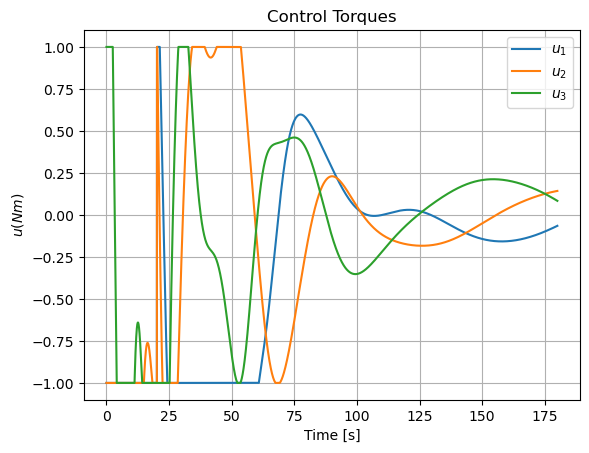

In [10]:
t = cc_sat_sim_results['t']
x = cc_sat_sim_results['x']
u = cc_sat_sim_results['u']
V = cc_sat_sim_results['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$u (Nm)$")
plt.title("Control Torques")
plt.legend()
plt.show()